In [1]:
import os
import argparse
import json
import numpy as np
import torch
import torch.nn as nn

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import umap                        

from utils.util import find_max_epoch, print_size, training_loss, calc_diffusion_hyperparams
from utils.util import get_mask_mnr, get_mask_bm, get_mask_rm

from imputers.DiffWaveImputer import DiffWaveImputer
from imputers.SSSDSAImputer import SSSDSAImputer
from imputers.SSSDS4Imputer import SSSDS4Imputer


CUDA extension for cauchy multiplication not found. Install by going to extensions/cauchy/ and running `python setup.py install`. This should speed up end-to-end training by 10-50%
Falling back on slow Cauchy kernel. Install at least one of pykeops or the CUDA extension for efficiency.


In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('-c', '--config', type=str, default='./config/config_SSSDS4-sp500.json')  
# parser.add_argument('-c', '--config', type=str, default='./config/config_DiffWave-sp500.json') 
                                                                                                                                                                                                                               
args = parser.parse_args(args=[])

with open(args.config) as f:
    data = f.read()

config = json.loads(data)

In [3]:
train_config = config["train_config"]  # training parameters

global trainset_config
trainset_config = config["trainset_config"]  # to load trainset

global diffusion_config
diffusion_config = config["diffusion_config"]  # basic hyperparameters

global diffusion_hyperparams
diffusion_hyperparams = calc_diffusion_hyperparams(
                      **diffusion_config)  # dictionary of all diffusion hyperparameters

global model_config

if train_config['use_model'] == 0:
    model_config = config['wavenet_config']
elif train_config['use_model'] == 1:
    model_config = config['sashimi_config']
elif train_config['use_model'] == 2:
    model_config = config['wavenet_config']
       
model_config['num_res_layers']=18           

In [5]:
output_directory = './results/mujoco/90'
ckpt_iter = 'max'
n_iters = 10000
iters_per_ckpt = 100
iters_per_logging = 100
# batch_size_per_gpu              
learning_rate = 0.0002
use_model = 2
only_generate_missing = 1       
masking = 'rm'               
missing_k = 20

In [6]:
local_path = "T{}_beta0{}_betaT{}".format(diffusion_config["T"],
                                              diffusion_config["beta_0"],
                                              diffusion_config["beta_T"])

output_directory = os.path.join(output_directory, local_path)
if not os.path.isdir(output_directory):
    os.makedirs(output_directory)
    os.chmod(output_directory, 0o775)               
print("output directory", output_directory, flush=True)

# map diffusion hyperparameters to gpu
for key in diffusion_hyperparams:
    if key != "T":
        diffusion_hyperparams[key] = diffusion_hyperparams[key].cuda()
        
        
# predefine model
if use_model == 0:
    net = DiffWaveImputer(**model_config).cuda()
elif use_model == 1:
    net = SSSDSAImputer(**model_config).cuda()
elif use_model == 2:
    net = SSSDS4Imputer(**model_config).cuda()    
else:
    print('Model chosen not available.')
    
print_size(net)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

output directory ./results/mujoco/90\T200_beta00.0001_betaT0.02
SSSDS4Imputer Parameters: 7.547142M


In [7]:
training_data = np.load(trainset_config['train_data_path'])
np.random.shuffle(training_data)
print(training_data.shape)

(5775, 30, 6)


In [8]:
training_data = np.split(training_data, 55, 0)      
print(len(training_data), training_data[0].shape)

training_data = np.array(training_data)
training_data = torch.from_numpy(training_data).float().cuda()
print(training_data.shape)


55 (105, 30, 6)
torch.Size([55, 105, 30, 6])


In [9]:
missing_k = 20                    
iters = 0
loss_list=[]

# while iters < n_iters + 1:

#     for batch in training_data:             
#         transposed_mask = get_mask_rm(batch[0], missing_k)     
#         mask = transposed_mask.permute(1, 0)    
#         mask = mask.repeat(batch.size()[0], 1, 1).float().cuda()  
#         loss_mask = ~mask.bool()        
#         batch = batch.permute(0, 2, 1)   
#         optimizer.zero_grad()
#         X = batch, batch, mask, loss_mask    
#         loss = training_loss(net, nn.MSELoss(), X, diffusion_hyperparams,
#                              only_generate_missing=only_generate_missing)

#         loss.backward()
#         optimizer.step()
           
#         if iters % iters_per_logging == 0:
#                 print("iteration: {} \tloss: {}".format(iters, loss.item()))
                
#         loss_list.append(loss.item())
        
#         iters += 1
  

In [9]:
# torch.save( net.state_dict(),"./sp500_S4_iter_10000.pth" )

In [10]:
net = SSSDS4Imputer(**model_config).cuda()
net.load_state_dict(torch.load( "./sp500_S4_iter_10000.pth"))

# net.eval()

<All keys matched successfully>

In [13]:
def std_normal(size):
    """
    Generate the standard Gaussian variable of a certain size
    """
    return torch.normal(0, 1, size=size).cuda()


size=(5775,6,30)

_dh = diffusion_hyperparams
T, Alpha, Alpha_bar, Sigma = _dh["T"], _dh["Alpha"], _dh["Alpha_bar"], _dh["Sigma"]

assert len(Alpha) == T
assert len(Alpha_bar) == T
assert len(Sigma) == T
assert len(size) == 3

# print(T, Alpha)

x = std_normal(size)      # xT  
cond = 1
mask = 1


In [13]:
with torch.no_grad():      
        for t in range(T - 1, -1, -1):              
            diffusion_steps = (t * torch.ones((size[0], 1))).cuda()  # use the corresponding reverse step             
            epsilon_theta = net((x, cond, mask, diffusion_steps,))  # predict \epsilon according to \epsilon_\theta 
            x = (x - (1 - Alpha[t]) / torch.sqrt(1 - Alpha_bar[t]) * epsilon_theta) / torch.sqrt(Alpha[t])     
            if t > 0:
                x = x + Sigma[t] * std_normal(size)  
                     

In [14]:
result = x.permute(0, 2, 1)

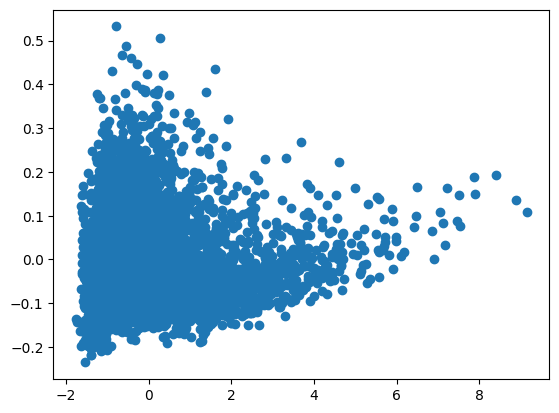

In [15]:
result = result.cpu().numpy().reshape(5775,-1)
# result = result.cpu().numpy().reshape(-1,14)[0:2000]

pca = PCA(2)
pca_res1 = pca.fit_transform(result)

plt.figure()
plt.scatter(pca_res1[:,0],pca_res1[:,1])

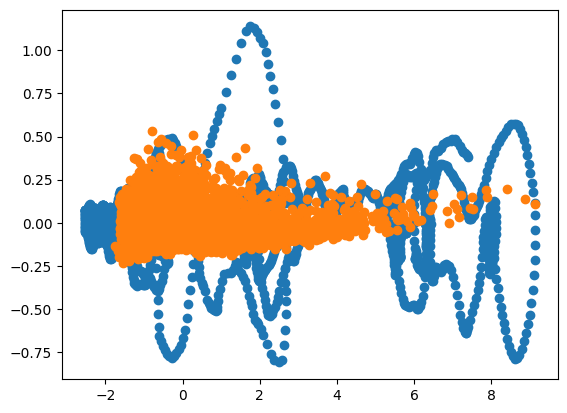

In [16]:
training_data = np.load(trainset_config['train_data_path'])
np.random.shuffle(training_data)
ori_data = training_data.reshape(5775,-1)

pca = PCA(2)
pca_res = pca.fit_transform(ori_data)

plt.figure()
plt.scatter(pca_res[:,0],pca_res[:,1])
plt.scatter(pca_res1[:,0],pca_res1[:,1])

In [17]:
concat_data = np.concatenate((result, ori_data), axis=0)
tsne = TSNE(n_components=2, verbose=1, perplexity=40,random_state=20,n_iter=500)    # 固定随机种子random_state=20
tsne_results = tsne.fit_transform(concat_data) 

C:\Users\PC123\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\PC123\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 11550 samples in 0.003s...
[t-SNE] Computed neighbors for 11550 samples in 0.589s...
[t-SNE] Computed conditional probabilities for sample 1000 / 11550
[t-SNE] Computed conditional probabilities for sample 2000 / 11550
[t-SNE] Computed conditional probabilities for sample 3000 / 11550
[t-SNE] Computed conditional probabilities for sample 4000 / 11550
[t-SNE] Computed conditional probabilities for sample 5000 / 11550
[t-SNE] Computed conditional probabilities for sample 6000 / 11550
[t-SNE] Computed conditional probabilities for sample 7000 / 11550
[t-SNE] Computed conditional probabilities for sample 8000 / 11550
[t-SNE] Computed conditional probabilities for sample 9000 / 11550
[t-SNE] Computed conditional probabilities for sample 10000 / 11550
[t-SNE] Computed conditional probabilities for sample 11000 / 11550
[t-SNE] Computed conditional probabilities for sample 11550 / 11550
[t-SNE] Mean sigma: 0.064924
[t-SNE] KL divergenc

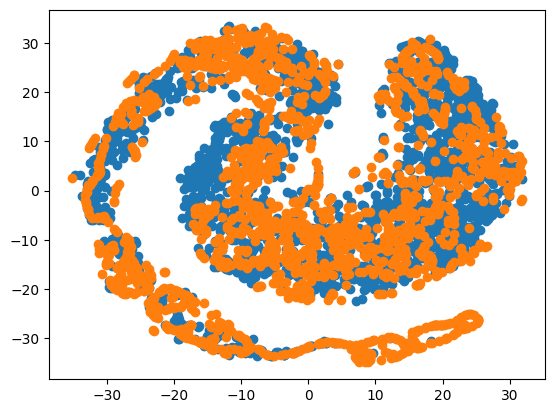

In [18]:
plt.figure()
plt.scatter(tsne_results[:2000,0],tsne_results[:2000,1])
plt.scatter(tsne_results[5775:7775,0],tsne_results[5775:7775,1])

C:\Users\PC123\anaconda3\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
C:\Users\PC123\AppData\Local\Temp\ipykernel_13408\135986510.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedding[:2000, 0], embedding[:2000, 1],  cmap='Spectral', s=5)
C:\Users\PC123\AppData\Local\Temp\ipykernel_13408\135986510.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedding[5775:7775, 0], embedding[5775:7775, 1],  cmap='Spectral', s=5)


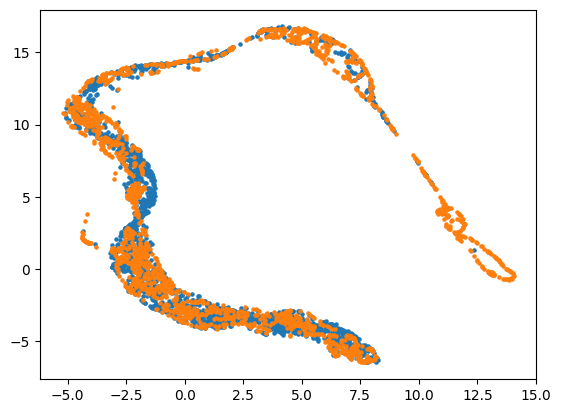

In [19]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(concat_data)

plt.figure()
plt.scatter(embedding[:2000, 0], embedding[:2000, 1],  cmap='Spectral', s=5)
plt.scatter(embedding[5775:7775, 0], embedding[5775:7775, 1],  cmap='Spectral', s=5)

In [20]:
ori_data = training_data
generated_data = x.permute(0, 2, 1).cpu().numpy()

anal_sample_no = min([4000, len(ori_data)])      
idx = np.random.permutation(len(ori_data))[:anal_sample_no]

ori_data = np.asarray(ori_data)
generated_data = np.asarray(generated_data)

ori_data = ori_data[idx]
generated_data = generated_data[idx]

for i in range(4000):
    if i == 0:
        prep_data = np.reshape(np.mean(ori_data[0, :, :], 1), [1, 30])
        
    else:
        prep_data = np.concatenate(
            (prep_data, np.reshape(np.mean(ori_data[i, :, :], 1), [1, 30]))
        )


for i in range(4000):
    if i == 0:
        prep_data1 = np.reshape(np.mean(generated_data[0, :, :], 1), [1, 30])
        
    else:
        prep_data1 = np.concatenate(
            (prep_data1, np.reshape(np.mean(generated_data[i, :, :], 1), [1, 30]))
        )
        
x2 = np.concatenate((prep_data, prep_data1), axis=0)

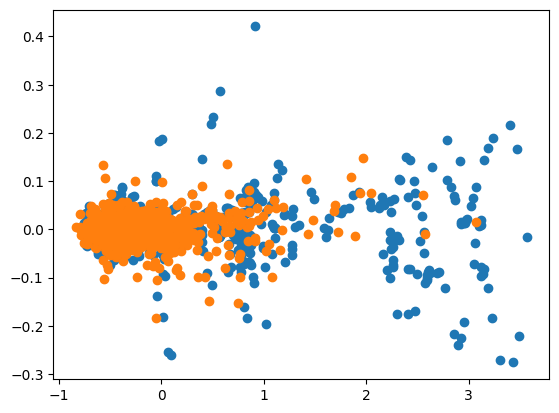

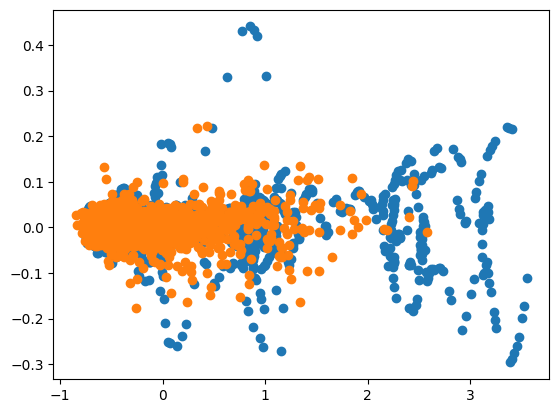

In [21]:
pca = PCA(2)
pca_res = pca.fit_transform(x2)

indexe1=np.random.permutation(4000)[:1000]
indexe2=np.random.permutation( range(4000,8000) )[:1000]

plt.figure()
plt.scatter(pca_res[indexe1,0],pca_res[indexe1,1])
plt.scatter(pca_res[indexe2,0],pca_res[indexe2,1])

plt.figure()
plt.scatter(pca_res[:2000,0],pca_res[:2000,1])
plt.scatter(pca_res[4000:6000,0],pca_res[4000:6000,1])

In [22]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40,random_state=20,n_iter=500)    
tsne_results = tsne.fit_transform(x2)           

C:\Users\PC123\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\PC123\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 8000 samples in 0.000s...
[t-SNE] Computed neighbors for 8000 samples in 0.186s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8000
[t-SNE] Computed conditional probabilities for sample 2000 / 8000
[t-SNE] Computed conditional probabilities for sample 3000 / 8000
[t-SNE] Computed conditional probabilities for sample 4000 / 8000
[t-SNE] Computed conditional probabilities for sample 5000 / 8000
[t-SNE] Computed conditional probabilities for sample 6000 / 8000
[t-SNE] Computed conditional probabilities for sample 7000 / 8000
[t-SNE] Computed conditional probabilities for sample 8000 / 8000
[t-SNE] Mean sigma: 0.014853
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.588799
[t-SNE] KL divergence after 500 iterations: 1.258977


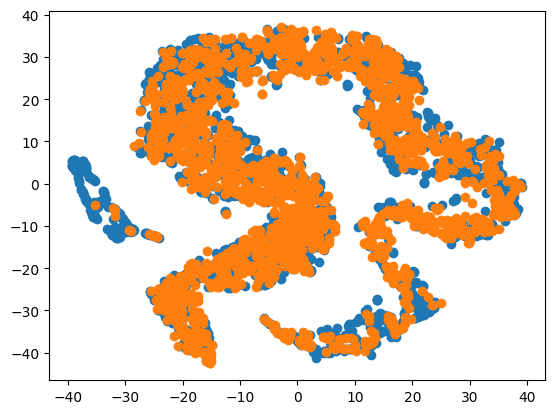

In [23]:
plt.figure()
plt.scatter(tsne_results[:2000,0],tsne_results[:2000,1])
plt.scatter(tsne_results[4000:6000,0],tsne_results[4000:6000,1])